In [1]:
#import linear algebra and data manipulation libraries
import numpy as np
import pandas as pd

#import date manipulation
import datetime as dt
from datetime import date, timedelta

#import standard visualization
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning
from sklearn.linear_model import LinearRegression
import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics

# import helpers
import re

## Introduction

I have recently joined Kaggle and started to create public kernels. My kernels have a lot of views, but no upvotes. So I decided to analyze Meta Kaggle dataset to find out:
* Statistics for kernels, which have votes.
* How different factors affect the number of votes (for example, characteristics of the author, source dataset etc.)?
* And finally, make the recommendations on how to make the kernel useful, so other kagglers would cast upvotes.

## Import datasets related to kernels

In [2]:
kernels = pd.read_csv('../input/Kernels.csv')
kernel_lang = pd.read_csv('../input/KernelLanguages.csv')
kernel_tags = pd.read_csv('../input/KernelTags.csv')
kernel_votes = pd.read_csv('../input/KernelVotes.csv')
kernel_versions = pd.read_csv('../input/KernelVersions.csv')
kernel_competitions = pd.read_csv('../input/KernelVersionCompetitionSources.csv')
kernel_users = pd.read_csv('../input/Users.csv')
datasets = pd.read_csv('../input/Datasets.csv')
kernel_datasets = pd.read_csv('../input/KernelVersionDatasetSources.csv')
dataset_versions = pd.read_csv('../input/DatasetVersions.csv')
tags = pd.read_csv('../input/Tags.csv')
competitions = pd.read_csv('../input/Competitions.csv')
messages = pd.read_csv('../input/ForumMessages.csv')

## Explore statistics for kernel votes

### 1. Explore basic statistics for number of kernels

* How many kernels are there? 
* How many of them are public? 
* How many kernels have upvotes? 
* How many kernels have any medal?

In [3]:
total_kernels = len(kernels['Id'].unique())
print('Total number of kernels: {total_kernels}'.format(total_kernels = total_kernels))

total_public = len(kernels[pd.notnull(kernels['MadePublicDate'])])
print('Total number of public kernels: {total_public_kernels}'.format(total_public_kernels = total_public))

total_upvoted = len(kernels[ kernels['TotalVotes'] > 0])
print('Total number of kernels with upvotes: {total_upvoted}'.format(total_upvoted = total_upvoted))

total_awarded = len(kernels[np.isfinite(kernels['Medal'])])
print('Total number of kernels with any medal: {total_awarded}'.format(total_awarded = total_awarded))

total_no_upvotes = total_public - total_upvoted
print('Total number of public kernels with no upvotes: {total_no_upvotes}'.format(total_no_upvotes = total_no_upvotes))

total_private = total_kernels - total_public
print('Total number of private kernels: {total_private}'.format(total_private = total_private))

total_upvoted_not_awarded = total_upvoted - total_awarded
print('Total number of upvoted, but not awarded: {total_upvoted_not_awarded}'.format(total_upvoted_not_awarded = total_upvoted_not_awarded))

Total number of kernels: 262549
Total number of public kernels: 242707
Total number of kernels with upvotes: 60805
Total number of kernels with any medal: 11828
Total number of public kernels with no upvotes: 181902
Total number of private kernels: 19842
Total number of upvoted, but not awarded: 48977


Plot statistics for number of kernels:

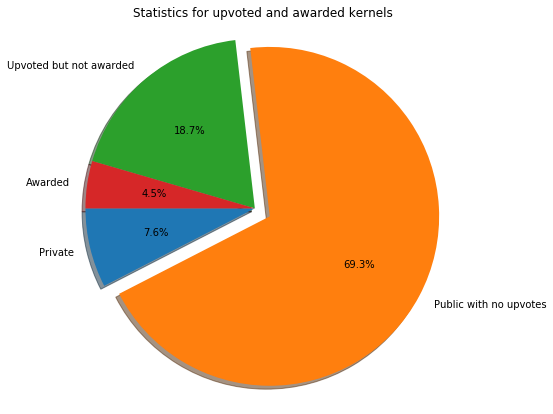

In [4]:
#plot statistics with matplotlib

labels = 'Private', 'Public with no upvotes', 'Upvoted but not awarded', 'Awarded'
sizes = [total_private, total_no_upvotes, total_upvoted_not_awarded, total_awarded]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=180)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

fig1.set_figheight(7)
fig1.set_figwidth(7)

plt.title('Statistics for upvoted and awarded kernels')

plt.show()

### 2. How does number of views and number of comments affect number of votes?

* Is there a correlation between number of views and number of comments with number of votes?
* Plot dependencies between number of views, comments and number of votes.

Find out correlation between number of views, number of comments and number of votes:

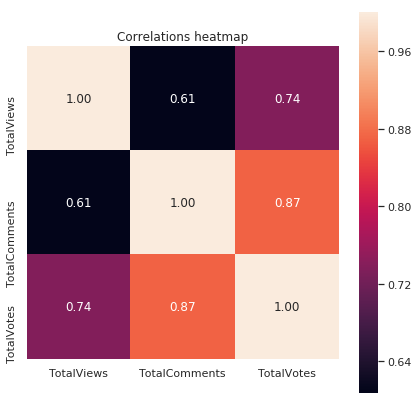

In [5]:
#columns to find out correlation
cols = ['TotalViews', 'TotalComments', 'TotalVotes']

#Find out correlation between columns and plot
corrs = np.corrcoef(kernels[cols].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(7,7)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols).set_title('Correlations heatmap')

fig = hm.get_figure()
fig.savefig('correlations.png')

We can see that votes, comments and views are __highly correlated__. So my first assumption would be that __we should get as many views of the kernels as possible to gain votes__.
<br> Let's try to visualize dependency between views and votes:

In [6]:
#get average number of votes per number of views
votes_by_views = kernels.groupby('TotalViews').mean().reset_index()[['TotalViews', 'TotalVotes']]
votes_by_views = votes_by_views.sort_values(by = 'TotalViews', ascending = True)

# fit a linear regression model on views and votes data
model = LinearRegression()
model.fit(votes_by_views['TotalViews'].values.reshape(-1, 1), votes_by_views['TotalVotes'].values.reshape(-1, 1))

inputs = np.linspace(1, 1200000, num=50)
predictions = model.predict(inputs.reshape(-1,1))

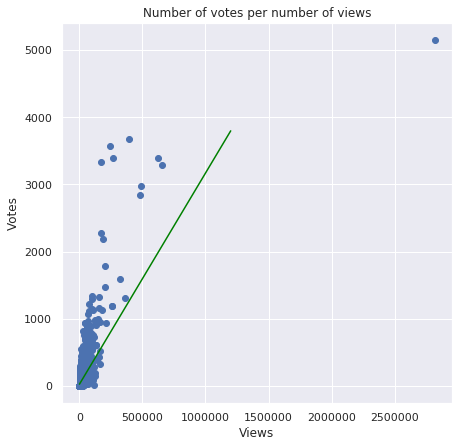

In [7]:
#plot with matplotlib along with predictions from the linear regression model

plt.scatter(votes_by_views['TotalViews'], votes_by_views['TotalVotes'])
plt.plot(inputs, predictions, color='green')

plt.title("Number of votes per number of views")
plt.xlabel("Views")
plt.ylabel("Votes")

plt.show()

Visualization of dependency between comments and votes:

In [8]:
#get average number of votes per number of comments
votes_by_comments = kernels.groupby('TotalComments').mean().reset_index()[['TotalComments', 'TotalVotes']]
votes_by_comments = votes_by_comments.sort_values(by = 'TotalComments', ascending = True)

# fit a linear regression model on comments and votes data
model = LinearRegression()
model.fit(votes_by_comments['TotalComments'].values.reshape(-1, 1), votes_by_comments['TotalVotes'].values.reshape(-1, 1))

inputs = np.linspace(1, 1000, num=50)
predictions = model.predict(inputs.reshape(-1,1))

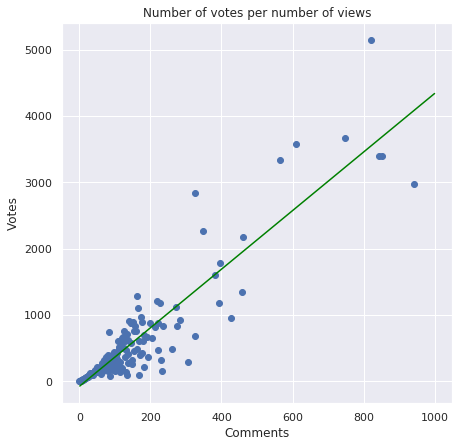

In [9]:
#plot with matplotlib along with predictions from the linear regression model

plt.scatter(votes_by_comments['TotalComments'], votes_by_comments['TotalVotes'])
plt.plot(inputs, predictions, color='green')

plt.title("Number of votes per number of views")
plt.xlabel("Comments")
plt.ylabel("Votes")

plt.show()

Both plots for the views and the comments show us that there is linear dependency between number of votes and number of views/comments.

### 3. How does the status of the author affect number of votes per kernel?

I suppose that more active users and the users with higher visibility gain votes for kernels:
* So how does performance tier of the user affect the number of upvotes?

In [10]:
#merge kernels with users
kernel_users_renamed = kernel_users.rename(columns={'Id': 'AuthorUserId'})
kernels_user_tiers = kernels.merge(kernel_users_renamed, on = 'AuthorUserId')

#get average number of votes per number of comments
votes_by_usertier= kernels_user_tiers.groupby('PerformanceTier').mean().reset_index()[['PerformanceTier', 'TotalVotes']]
votes_by_usertier = votes_by_usertier.sort_values(by = 'PerformanceTier', ascending = True)

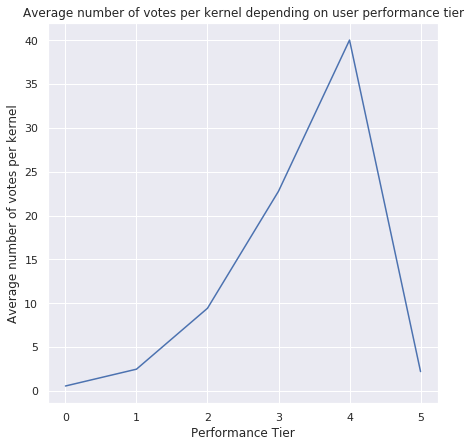

In [11]:
#plot with matplotlib along with predictions from the linear regression model

plt.plot(votes_by_usertier['PerformanceTier'], votes_by_usertier['TotalVotes'])

plt.title("Average number of votes per kernel depending on user performance tier")
plt.xlabel("Performance Tier")
plt.ylabel("Average number of votes per kernel")

plt.show()

So we can really see that __more proficient users gain more votes for kernels__.

### 4. How does dataset related to kernel affects the number of votes?

I suppose that there might be some 'hot' datasets on Kaggle and kernels related to those datasets might optain more votes. So we should find out:
* How does the number of votes for a dataset affect the number of votes for related kernel?
* How does the number of downloads of a dataset affect the number of votes for related kernel?

In [12]:
#prepare data for the analysis

kernels_truncated = kernels[['Id' , 'CurrentKernelVersionId', 'TotalVotes']]
kernels_truncated = kernels_truncated.rename(columns={'Id': 'KernelId', 'TotalVotes':'TotalKernelVotes',
                                                      'CurrentKernelVersionId':'KernelVersionId'})

kernel_datasets_truncated = kernel_datasets[['KernelVersionId', 'SourceDatasetVersionId']]

dataset_versions_truncated = dataset_versions[['DatasetId', 'DatasourceVersionId']]
dataset_versions_truncated = dataset_versions_truncated.rename(columns={'DatasourceVersionId': 'SourceDatasetVersionId'})

datasets_truncated = datasets[['Id', 'TotalVotes', 'TotalDownloads']]
datasets_truncated = datasets_truncated.rename(columns={'Id': 'DatasetId', 'TotalVotes':'TotalDatasetVotes',
                                                      'TotalDownloads':'TotalDatasetDownloads'})

df_merge = kernels_truncated.merge(kernel_datasets_truncated, on = 'KernelVersionId')
df_merge = df_merge.merge(dataset_versions_truncated, on = 'SourceDatasetVersionId')
df_merge = df_merge.merge(datasets_truncated, on = 'DatasetId')

At first let's look at correlations between TotalKernelVotes, TotalDatasetVotes and	TotalDatasetDownloads.

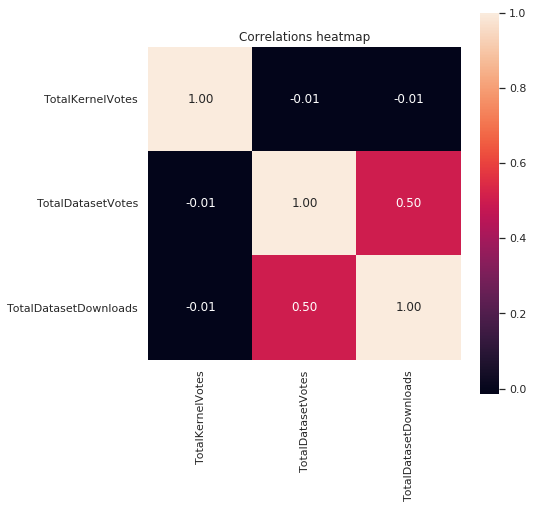

In [13]:
#columns to find out correlation
cols = ['TotalKernelVotes', 'TotalDatasetVotes', 'TotalDatasetDownloads']

#Find out correlation between columns and plot
corrs = np.corrcoef(df_merge[cols].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(7,7)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols).set_title('Correlations heatmap')

plt.yticks(rotation=0)
fig = hm.get_figure()
fig.savefig('correlations.png')

As we can see there is no correlation between number of kernel votes and number of votes or downloads for a dataset.
<br> Let's also make scatter plots:

In [14]:
#get average number of votes per number of dataset votes
votes_by_dvotes = df_merge.groupby('TotalDatasetVotes').mean().reset_index()[['TotalDatasetVotes', 'TotalKernelVotes']]
votes_by_dvotes = votes_by_dvotes.sort_values(by = 'TotalDatasetVotes', ascending = True)

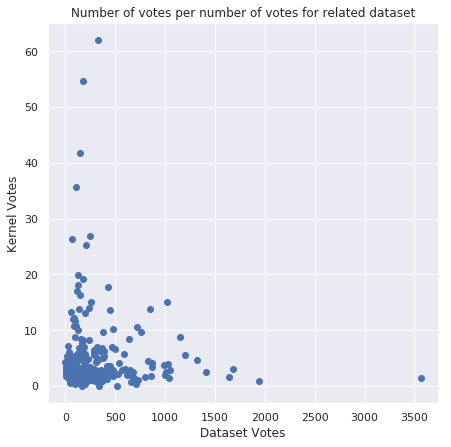

In [15]:
#plot with matplotlib

plt.scatter(votes_by_dvotes['TotalDatasetVotes'], votes_by_dvotes['TotalKernelVotes'])

plt.title("Number of votes per number of votes for related dataset")
plt.xlabel("Dataset Votes")
plt.ylabel("Kernel Votes")

plt.show()

Here we can't see a clear dependency of kernel votes on dataset's number of votes. So I suppose that we can create a really helpful and popular kernel for an unpopular dataset and vice versa.

In [16]:
#get average number of votes per number of dataset downloads
votes_by_downloads = df_merge.groupby('TotalDatasetDownloads').mean().reset_index()[['TotalDatasetDownloads', 'TotalKernelVotes']]
votes_by_downloads = votes_by_downloads.sort_values(by = 'TotalDatasetDownloads', ascending = True)

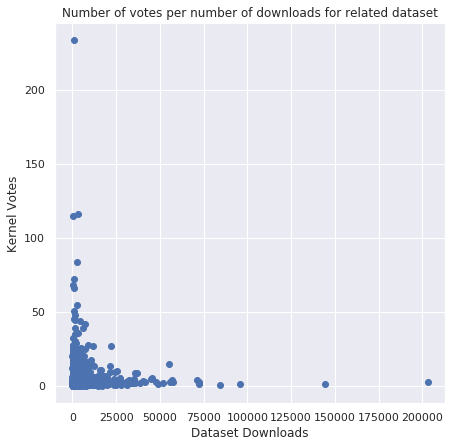

In [17]:
#plot with matplotlib

plt.scatter(votes_by_downloads['TotalDatasetDownloads'], votes_by_downloads['TotalKernelVotes'])

plt.title("Number of votes per number of downloads for related dataset")
plt.xlabel("Dataset Downloads")
plt.ylabel("Kernel Votes")

plt.show()

The picture looks similar to the previous one. There is also no clear dependency.

### 6. How does kernel language affect the number of votes?

What kernel types gain more votes?

In [18]:
#prepare the data for the analysis

kernels_trc = kernels[['Id' , 'TotalVotes', 'CurrentKernelVersionId']]
kernels_trc = kernels_trc.rename(columns = {'Id': 'KernelId', 'CurrentKernelVersionId' : 'VersionId'})

kernel_versions_trc = kernel_versions[['Id', 'KernelId', 'KernelLanguageId']]
kernel_versions_trc = kernel_versions_trc.rename(columns = {'Id' : 'VersionId'})

kernel_lang_ren = kernel_lang.rename(columns = {'Id' : 'KernelLanguageId'})

kernels_trc_lang = kernels_trc.merge(kernel_versions_trc, on = ['VersionId', 'KernelId'])
kernels_trc_lang = kernels_trc_lang.merge(kernel_lang_ren, on = 'KernelLanguageId')

In [19]:
#get average number of votes per language name
votes_by_lang = kernels_trc_lang.groupby('Name').mean().reset_index()[['Name', 'TotalVotes']]
votes_by_lang = votes_by_lang.sort_values(by = 'Name', ascending = True)
votes_by_lang = votes_by_lang.rename(columns = {'TotalVotes' : 'Average Votes'})

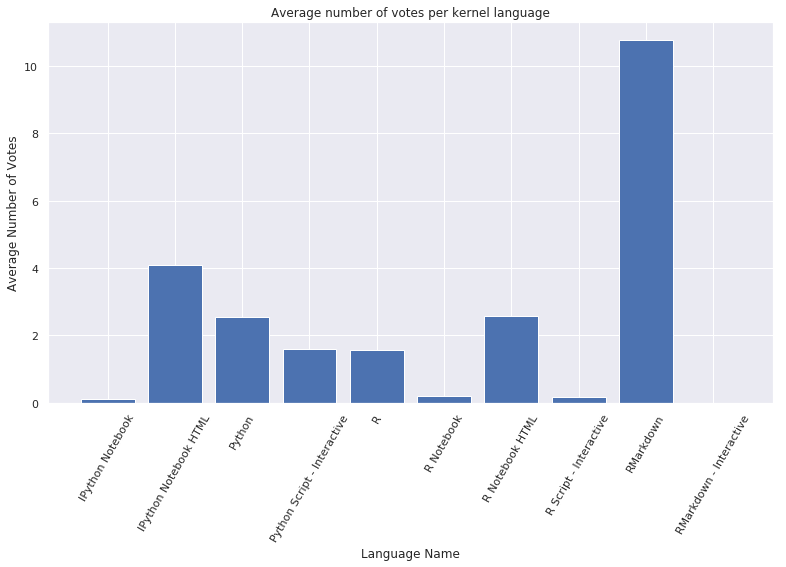

In [20]:
#plot bar chart with matplotlib

plt.figure(figsize=(13,7))
plt.bar(votes_by_lang['Name'], votes_by_lang['Average Votes'])
plt.xticks(votes_by_lang['Name'])
plt.xticks(rotation=60)

plt.xlabel('Language Name')
plt.ylabel('Average Number of Votes')

plt.title('Average number of votes per kernel language')

plt.show()

It seems that notebooks are more appreciated with Kaggle users. 

### 7. How do kernel tags affect the number of votes?

Now we will look at the kernels' tags:
* Are there any kernel tags, which are more specific to more popular kernels?

In [21]:
#prepare data

kernels_trc_tag = kernels[['Id' , 'TotalVotes']]
kernels_trc_tag = kernels_trc_tag.rename(columns = {'Id' : 'KernelId'})

tags_trc = tags[['Id', 'Name', 'DatasetCount', 'CompetitionCount', 'KernelCount']]
tags_trc = tags_trc.rename(columns = {'Id' : 'TagId'})

kernels_trc_tag = kernels_trc_tag.merge(kernel_tags[['KernelId', 'TagId']], on='KernelId')
kernels_trc_tag = kernels_trc_tag.merge(tags_trc, on = 'TagId')

I have an assumption that Kaggle users may be attracted by most popular tags, so using them will help to gain more votes. That is why I will try to plot average number of votes against number of datasets/competitions/kernels, where kernel tag is used.

1. Tag usage for datasets:

In [22]:
#get average number of votes per number of tage usages in datasets
votes_by_tag_dataset = kernels_trc_tag.groupby('DatasetCount').mean().reset_index()[['DatasetCount', 'TotalVotes']]
votes_by_tag_dataset = votes_by_tag_dataset.sort_values(by = 'DatasetCount', ascending = True)

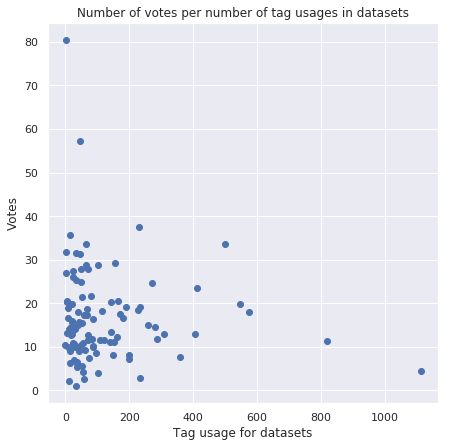

In [23]:
#plot with matplotlib

plt.scatter(votes_by_tag_dataset['DatasetCount'], votes_by_tag_dataset['TotalVotes'])
plt.title("Number of votes per number of tag usages in datasets")
plt.xlabel("Tag usage for datasets")
plt.ylabel("Votes")

plt.show()

2. Tag usage for competitions:

In [24]:
#get average number of votes per number of tage usages in competitions
votes_by_tag_competition = kernels_trc_tag.groupby('CompetitionCount').mean().reset_index()[['CompetitionCount', 'TotalVotes']]
votes_by_tag_competition = votes_by_tag_competition.sort_values(by = 'CompetitionCount', ascending = True)

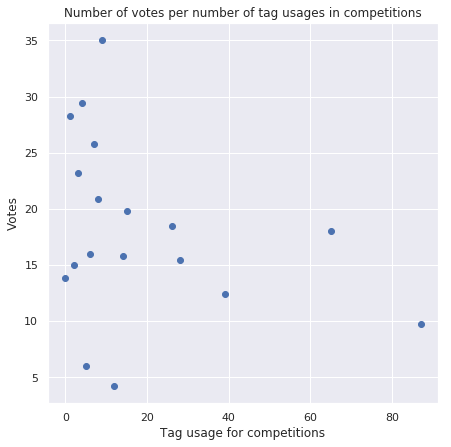

In [25]:
#plot with matplotlib

plt.scatter(votes_by_tag_competition['CompetitionCount'], votes_by_tag_competition['TotalVotes'])
plt.title("Number of votes per number of tag usages in competitions")
plt.xlabel("Tag usage for competitions")
plt.ylabel("Votes")

plt.show()

3. Tag usage for kernels:

In [26]:
#get average number of votes per number of tage usages in kernels
votes_by_tag_kernel = kernels_trc_tag.groupby('KernelCount').mean().reset_index()[['KernelCount', 'TotalVotes']]
votes_by_tag_kernel = votes_by_tag_kernel.sort_values(by = 'KernelCount', ascending = True)

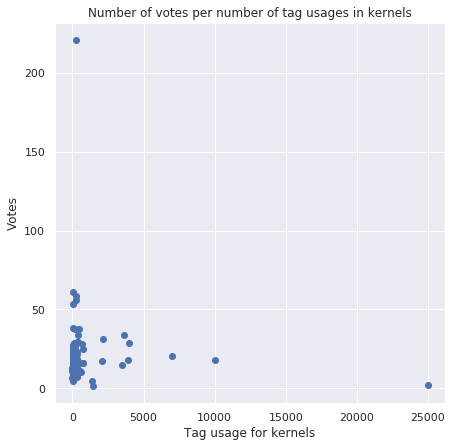

In [27]:
#plot with matplotlib

plt.scatter(votes_by_tag_kernel['KernelCount'], votes_by_tag_kernel['TotalVotes'])
plt.title("Number of votes per number of tag usages in kernels")
plt.xlabel("Tag usage for kernels")
plt.ylabel("Votes")

plt.show()

Looks like the popularity of the tag doesn't really affect the number of votes.
<br> I would also like to look at average number of votes for the most popular tags:

In [28]:
#find out total usage of the tag and store in TotalCount column
tags_total = tags_trc.copy()

tags_total['TotalCount'] = tags_total['DatasetCount'] + tags_total['CompetitionCount'] + tags_total['KernelCount']

#find out top-20 most popular tags
tags_total = tags_total.sort_values('TotalCount', ascending = False)
tags_total = tags_total[:20]

#find average number of votes for each tag
votes_by_tag = kernels_trc_tag.groupby('Name').mean().reset_index()[['Name', 'TotalVotes']]

#filter votes by tag for only top-20 most popular tags
votes_by_tag_popular = votes_by_tag[votes_by_tag['Name'].isin(tags_total['Name'].values.tolist())]

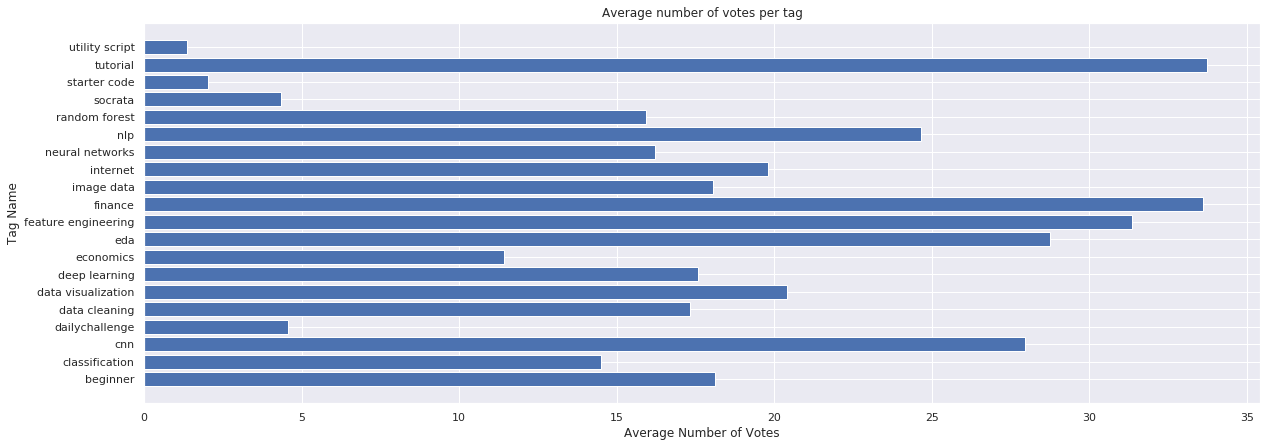

In [29]:
#plot bar chart with matplotlib

plt.figure(figsize=(20,7))
plt.barh(votes_by_tag_popular['Name'], votes_by_tag_popular['TotalVotes'])
plt.yticks(votes_by_tag_popular['Name'])

plt.ylabel('Tag Name')
plt.xlabel('Average Number of Votes')

plt.title('Average number of votes per tag')

plt.show()

We can really see that number of votes varies greatly even for the most popular tags.
<br> It is also interesting to find out tags, which have the greatest average number of votes:

In [30]:
#sort votes_by_tag by average number of votes and take top-20

votes_by_tag_aver = votes_by_tag.sort_values('TotalVotes', ascending = False)[:20]

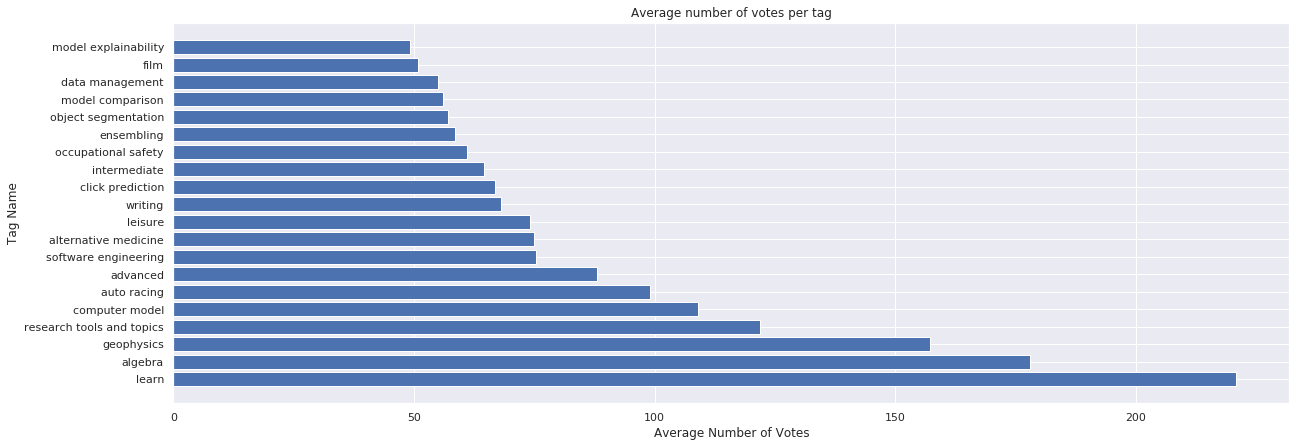

In [31]:
#plot bar chart with matplotlib

plt.figure(figsize=(20,7))
plt.barh(votes_by_tag_aver['Name'], votes_by_tag_aver['TotalVotes'])
plt.yticks(votes_by_tag_aver['Name'])

plt.ylabel('Tag Name')
plt.xlabel('Average Number of Votes')

plt.title('Average number of votes per tag')

plt.show()

We can see that tags with the greatest average number of votes don't really match with the most popular tags, so I guess my assumption that using popular tags in kernels will help to gain more votes is wrong.

### 8. Does "advertising" of your kernel on Kaggle forums help to gain votes?

Mentioning a kernel in forum messages can potentially help to promote the kernel among kagglers and eventually get more votes. Let's analyze the correlation between the number of mentions of a kernel with its number of votes.

The process of obtaining the number of mentions in forum messages is illustrated on figure below:
1. Analyze the ForumMessages table:
    * Find all messages which contain urls.
    * Extract kernel name and name of the author from the url address.
2. Merge Kernels, KernelVersions and Users tables:
    * Find name of the author for the kernel.
    * Find the title of the kernel.
    * Translate the title as in url address.
3. Merge kernel titles and titles from url addresses where the names of the authors match. Count the number of rows for each kernel. 

![engineering steps](https://github.com/Lexie88rus/kaggle_kernel_votes_analysis/blob/master/kernel_promotions.png?raw=true)

`1.` Find all forum messages with urls to Kaggle and extract possible kernel titles from urls:

In [32]:
# create msg_ref dataframe by removing rows with empty messages from the original dataset
msg_ref = messages[['Id', 'Message']].dropna(subset = ['Message'])

# filter rows: find rows with messages which contain references to kaggle
msg_ref = msg_ref[msg_ref.Message.str.match('.*https://www.kaggle.com/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+.*')]

In [33]:
def get_referenced_object(row):
    '''
    Function returns the last part of the url.
    Example:
        input: 'https://www.kaggle.com/aleksandradeis/how-to-get-upvotes-for-a-kernel-on-kaggle'
        returns: 'how-to-get-upvotes-for-a-kernel-on-kaggle'
    '''
    # extract url from message
    url = re.findall('https://www.kaggle.com/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'\
                         , row['Message'])[0]
    
    # remove tags
    cleanr = re.compile('<.*?>')
    clean_url= re.sub(cleanr, '', url)
    
    # get the last part of url, which corresponds to kernel title
    ref = clean_url.split('/')[-1]
    
    return ref

def get_author(row):
    '''
    Function returns the last part of the url.
    Example:
        input: 'https://www.kaggle.com/aleksandradeis/how-to-get-upvotes-for-a-kernel-on-kaggle'
        returns: 'aleksandradeis'
    '''
    # extract url from message
    url = re.findall('https://www.kaggle.com/(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'\
                         , row['Message'])[0]
    
    # remove tags
    cleanr = re.compile('<.*?>')
    clean_url= re.sub(cleanr, '', url)
    
    # get the last part of url, which corresponds to kernel title
    author = clean_url.split('/')[-2]
    
    return author

# create column 'Ref' with the last part of the url
# which is the title of the kernel (in case of url to a kernel)
msg_ref['Ref'] = msg_ref.apply(lambda row: get_referenced_object(row),axis=1)
msg_ref['Ref_author'] = msg_ref.apply(lambda row: get_author(row),axis=1)

In [34]:
msg_ref.head()

,Id,Message,Ref,Ref_author
6554,5810,<p>I have the same feeling. especially after s...,5809,leaderboards-for-visit-spend-and-visit-date
7134,8250,"<p>This is our team, https://www.kaggle.com/te...",ailabs.,11892
7552,9207,<p>See this: https://www.kaggle.com/c/asap-aes...,issue-making-a-submission,1401
7553,8350,"<p>Questions #1, #5, #6 are identical to what ...",clarifications-of-received-time-diff-reporting...,1315
8937,6737,<p>The new competitions list page at https://w...,Competitions,www.kaggle.com


`2.` Merge kernel votes with kernel titles and preprocess kernel title as in url:

In [35]:
# merge kernel votes and kernel titles (for current kernel version)
kernel_title = kernels[['Id', 'AuthorUserId', 'CurrentKernelVersionId', 'TotalVotes']]\
.merge(kernel_versions[['Id', 'Title']].rename(columns={"Id": "CurrentKernelVersionId"}))

In [36]:
# merge kernel votes and kernel authors
kernel_title = kernel_title.merge(kernel_users[['Id', 'UserName']].rename(columns={"Id":"AuthorUserId"}))

In [37]:
def process_kernel_title(row):
    '''
    Function removes symbols from title, translates to lower case,
    and replaces spaces with '-'
    Example:
        input: 'How to get upvotes for a kernel on Kaggle?'
        returns: 'how-to-get-upvotes-for-a-kernel-on-kaggle'
    '''
    try:
        title = row['Title']

        # remove specific symbols and translate to lower case
        title_cleaned = re.sub('[!@#$%?*,.;:()]', '', title).lower()

        # replace spaces with '-'
        title_cleaned = title_cleaned.replace(' ', '-')
    except:
        return ' '
    return title_cleaned

# create column title_cleaned with preprocessed title as in url
kernel_title['title_cleaned'] = kernel_title.apply(lambda row: process_kernel_title(row),axis=1)

In [38]:
kernel_title.head()

,Id,AuthorUserId,CurrentKernelVersionId,TotalVotes,Title,UserName,title_cleaned
0,1,2505,205.0,0,hello,jeffmoser,hello
1,86,2505,2307564.0,6,Hi Python,jeffmoser,hi-python
2,107,2505,740.0,0,Yet another Python Sleep Test,jeffmoser,yet-another-python-sleep-test
3,108,2505,748.0,0,More Python Testing,jeffmoser,more-python-testing
4,4345,2505,8879.0,0,Kaggle.io Test,jeffmoser,kaggleio-test


`3.` Merge kernels and mentions in urls:

In [39]:
# merge kernels and messages (outer)
promotions = pd.merge(msg_ref, kernel_title, how='outer', left_on='Ref', right_on='title_cleaned',
         suffixes=('_messages', '_kernels'), copy=True)

# remove rows with NaN
promotions = promotions.dropna()

# remove rows with title_cleaned in ['', 'competitions', 'rules']
promotions = promotions[~promotions['title_cleaned'].isin(['', 'competitions', 'rules'])]

# remove rows where authors don't match

promotions = promotions[promotions['Ref_author'] == promotions['UserName']]
promotions.head()

,Id_messages,Message,Ref,Ref_author,Id_kernels,AuthorUserId,CurrentKernelVersionId,TotalVotes,Title,UserName,title_cleaned
2844,465343.0,<p>A kernel from a previous competition (<a hr...,customized-softkappa-loss-in-xgboost,chenglongchen,5901.0,102203.0,14152.0,20.0,Customized softkappa loss in XGBoost,chenglongchen,customized-softkappa-loss-in-xgboost
2921,428505.0,"<p>Hi, instead of ""removing randomly from the ...",data-augmentation,dansbecker,528798.0,9028.0,18612112.0,123.0,Data Augmentation,dansbecker,data-augmentation
3899,210910.0,<p>Eike shared a lot of insights. What he ment...,exploratory-analysis-rossmann,thie1e,19422.0,227184.0,124149.0,340.0,Exploratory Analysis Rossmann,thie1e,exploratory-analysis-rossmann
8699,240040.0,"<p><a href=""https://www.kaggle.com/issatingzon...",exploratory-data-analysis,issatingzon,390413.0,699774.0,1615052.0,12.0,Exploratory Data Analysis,issatingzon,exploratory-data-analysis
9068,448547.0,"<p>What is the difference with <a href=""https:...",data-dictionary,airbourne,2512037.0,639677.0,9058520.0,73.0,Data dictionary,airbourne,data-dictionary


`4.` Group by kernel id to find number of metions in forum messages:

In [40]:
n_promotions = promotions[['Id_kernels', 'CurrentKernelVersionId', 'TotalVotes']]\
.groupby('Id_kernels').count().reset_index()[["Id_kernels", "CurrentKernelVersionId"]]\
.rename(columns = {'CurrentKernelVersionId' : 'Promotions'})

`5.` Merge number of promotions with total votes:

In [41]:
n_kernel_promotions = kernels[['Id', 'TotalVotes', 'Medal']].merge(n_promotions.rename(columns = {'Id_kernels' : 'Id'})\
                                                          , how = 'outer')
n_kernel_promotions = n_kernel_promotions.fillna(0)

`6.` Analyze correlation between the number of votes and number of mentions in forum messages:

First of all let's plot the number of votes against the number of promotions in forum messages:

In [42]:
# fit a linear regression model on mentions and votes data
model = LinearRegression()
model.fit(n_kernel_promotions['Promotions'].values.reshape(-1, 1), n_kernel_promotions['TotalVotes'].values.reshape(-1, 1))

inputs = np.linspace(1, 20, num=50)
predictions = model.predict(inputs.reshape(-1,1)).reshape(50)

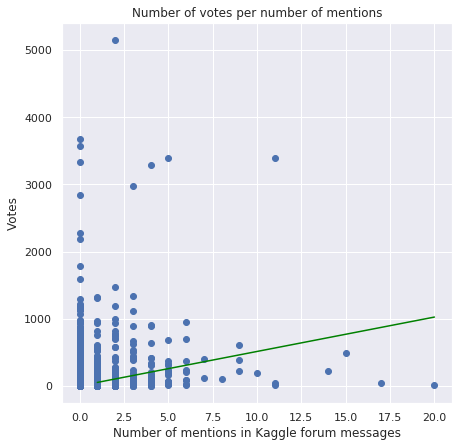

In [43]:
#plot with matplotlib

plt.scatter(n_kernel_promotions['Promotions'], n_kernel_promotions['TotalVotes'])
plt.plot(inputs, predictions, color='green')

plt.title("Number of votes per number of mentions")
plt.xlabel("Number of mentions in Kaggle forum messages")
plt.ylabel("Votes")

plt.show()

Let's check the correlation coefficient:

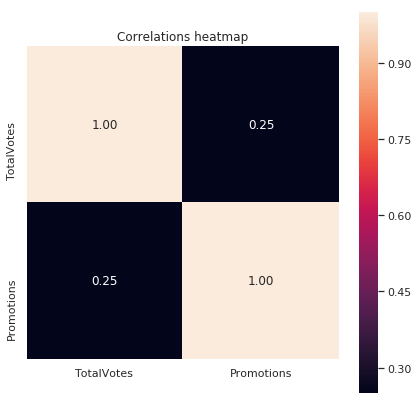

In [44]:
#columns to find out correlation
cols = ['TotalVotes', 'Promotions']

#Find out correlation between columns and plot
corrs = np.corrcoef(n_kernel_promotions[cols].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(7,7)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols).set_title('Correlations heatmap')

fig = hm.get_figure()

Find out the correlation between the medal rank and the number of mentions of the kernel:

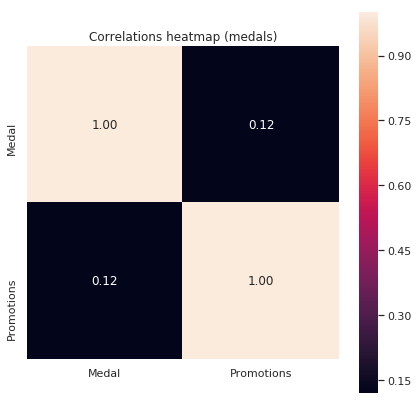

In [45]:
#columns to find out correlation
cols = ['Medal', 'Promotions']

#Find out correlation between columns and plot
corrs = np.corrcoef(n_kernel_promotions[cols].values.T)
sns.set(font_scale=1)
sns.set(rc={'figure.figsize':(7,7)})
hm=sns.heatmap(corrs, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = cols, xticklabels = cols).set_title('Correlations heatmap (medals)')

fig = hm.get_figure()

Finally, some numbers considering the number of mentions of the kernels on Kaggle forum:

In [46]:
votes_with_mentions = n_kernel_promotions[n_kernel_promotions['Promotions'] > 0]['TotalVotes'].mean()
print('Average number of votes for advertised kernels: {}'.format(votes_with_mentions))

kernels_with_promotions = n_kernel_promotions[n_kernel_promotions['Promotions'] > 0]['Promotions'].count()
print('Total number of kernels mentioned in forum messages: {}'.format(kernels_with_promotions))

votes_no_mentions = n_kernel_promotions[n_kernel_promotions['Promotions'] == 0]['TotalVotes'].mean()
print('Average number of votes for non advertised kernels: {}'.format(votes_no_mentions))

Average number of votes for advertised kernels: 78.38025210084034
Total number of kernels mentioned in forum messages: 1428
Average number of votes for non advertised kernels: 2.0942934501629513


Comparison of medal rank for kernels with mentions on Kaggle forums and kenels without mentions:

In [47]:
medals_with_mentions = n_kernel_promotions[n_kernel_promotions['Promotions'] > 0]['Medal'].mean()
print('Average medal rank for advertised kernels: {}'.format(medals_with_mentions))

medals_no_mentions = n_kernel_promotions[n_kernel_promotions['Promotions'] == 0]['Medal'].mean()
print('Average medal rank for non advertised kernels: {}'.format(medals_no_mentions))

Average medal rank for advertised kernels: 1.2808123249299719
Average medal rank for non advertised kernels: 0.11161492181785455


<b> Conclusions: </b>

* There is no strong correlation between the number of mentions in Kaggle messages and the number of votes.
* The average number of votes for advertised kernels is higher than the number of votes for non-advertised kernels.
* The average medal rank for advertised kernels is higher than the average medal rank for non-advertised kernels.


<br>My experience tells me that promoting your kernel on Kaggle forum helps to gain votes, but the analysis doesn't show that. Probably, this happens because the number of kernels mentioned in forum messages (and identified by me) is tiny, so we don't have enough data for the analysis. </br>

## Machine learning to predict number of votes for kernel

The last thing left to do is to try to create regression model, which predicts the number of votes for a kernel.

In [48]:
#prepare data

def has_tag(row, tag):
    ''' Function returns 1 of tag id found in row['Tags'] column '''
    
    for row_tag in row['Tags'].replace(' ','').replace('{','').replace('}','').split(','):
        if row_tag == tag:
            return 1
    return 0

def is_forked(row):
    ''' Functions returns 0 if row['ForkParentKernelVersionId'] is nan, 1 - otherwise '''
    if np.isnan(row['ForkParentKernelVersionId']):
        return 0
    else:
        return 1

def has_linked_topic(row):
    ''' Functions returns 0 if row['ForumTopicId'] is nan, 1 - otherwise '''
    if np.isnan(row['ForumTopicId']):
        return 0
    else:
        return 1
    
def get_days_from_registration(row):
    '''Function returns number of days since users registration date'''
    
    today = dt.datetime.now().date()
    days = (today - dt.datetime.strptime(row['RegisterDate'], "%m/%d/%Y").date()).days
    
    return days

def get_days_from_kernel_creation(row):
    '''Function returns number of days since kernel creation date'''
    
    today = dt.datetime.now().date()
    
    days = (today - dt.datetime.strptime(row['CreationDate'], "%m/%d/%Y %H:%M:%S").date()).days
    
    return days

def prepare_data(kernels, kernel_lang, kernel_tags, kernel_versions, kernel_users, kernel_datasets, datasets, dataset_versions, tags, competitions, kernel_competitions):
    '''
    Function to prepare meta Kaggle data to be used in regression models
    
    INPUTS:
    1. kernels - Kernels.csv dataset, 
    2. kernel_lang - KernelLanguages.csv dataset,
    3. kernel_tags - KernelTags.csv dataset,
    4. kernel_versions - KernelVersions.csv dataset,
    5. kernel_users - KernelUsers.csv dataset,
    6. kernel_datasets - KernelVersionDatasetSources.csv dataset,
    7. datasets - Datasets.csv dataset,
    8. dataset_versions - DatasetVersions.csv dataset,
    9. tags - Tags.csv dataset.
    
    RETURNS:
    df - dataset, wchich contains preprocessed data
    '''
    #1. merge datasets
    
    #remove irrelevant columns from dataset and rename other columns to perform merge
    df = kernels[['Id', 'CurrentKernelVersionId' , 'ForkParentKernelVersionId', 'ForumTopicId', 'TotalVotes', 'AuthorUserId', 'CreationDate']].rename(columns = 
                                                                                                                      {'Id': 'KernelId', 
                                                                                                           'TotalVotes': 'TotalKernelVotes', 
                                                                                                                      'CurrentKernelVersionId':'KernelVersionId'})
    
    # create new column for age of the kernel (number of days since the kernel creation)
    # and drop old column CreationDate
    df[['CreationDate']] = df[['CreationDate']].fillna(value=dt.datetime.now().strftime('%m/%d/%Y %H:%M:%S'))
    df['KernelAge'] = df.apply(lambda row: get_days_from_kernel_creation(row),axis=1)
    df = df.drop('CreationDate', axis = 1)
    
    #merge with users to add PerformanceTier of the author and number of days since author's registration on Kaggle
    kernel_users['DaysSinceRegistration'] = kernel_users.apply(lambda row: get_days_from_registration(row),axis=1)
    kernel_users_renamed = kernel_users[['Id', 'PerformanceTier', 'DaysSinceRegistration']].rename(columns={'Id': 'AuthorUserId',
                                                                                  'PerformanceTier' : 'AuthorPerformanceTier'})
    df = df.merge(kernel_users_renamed, on = 'AuthorUserId').drop('AuthorUserId', axis = 1)
    
    #merge with versions to add VersionNumber and KernelLanguageId
    kernel_versions_renamed = kernel_versions[['Id', 'KernelId', 'KernelLanguageId', 'VersionNumber']].rename(columns = {'Id':'KernelVersionId'})
    df = df.merge(kernel_versions_renamed, on = ['KernelVersionId', 'KernelId'])
    
    #merge with datasets to add TotalDatasetVotes and TotalDatasetDownloads
    kernel_datasets_truncated = kernel_datasets[['KernelVersionId', 'SourceDatasetVersionId']]

    dataset_versions_truncated = dataset_versions[['DatasetId', 'DatasourceVersionId']]
    dataset_versions_truncated = dataset_versions_truncated.rename(columns={'DatasourceVersionId': 'SourceDatasetVersionId'})

    datasets_truncated = datasets[['Id', 'TotalVotes', 'TotalDownloads']]
    datasets_truncated = datasets_truncated.rename(columns={'Id': 'DatasetId', 'TotalVotes':'TotalDatasetVotes',
                                                      'TotalDownloads':'TotalDatasetDownloads'})

    df = df.merge(kernel_datasets_truncated, on = 'KernelVersionId')
    df = df.merge(dataset_versions_truncated, on = 'SourceDatasetVersionId')
    df = df.merge(datasets_truncated, on = 'DatasetId').drop(['SourceDatasetVersionId', 'DatasetId'], axis = 1)
    
    # merge with type of competition
    # if kernel is not linked to a competition - NaN
    competitions_type = competitions[['Id', 'HostSegmentTitle']].rename(columns={'Id': 'SourceCompetitionId'})
    kernel_competition_type = kernel_competitions.merge(competitions_type, on='SourceCompetitionId')[['KernelVersionId', 'HostSegmentTitle']] # merge kernel versions with competitions
    df = df.merge(kernel_competition_type, on = 'KernelVersionId', how='outer')
    df = df.drop('KernelVersionId', axis = 1)
    
    #create dummy variables for competition types and drop HostSegmentTitle
    df = pd.get_dummies(df, columns = ['HostSegmentTitle'], prefix = 'comp', dummy_na = True)
       
    #merge with tags
    tags_trc = tags[['Id', 'Name']]
    tags_trc = tags_trc.rename(columns = {'Id' : 'TagId', 'Name' : 'TagName'})
    df = df.merge(kernel_tags, on = 'KernelId').drop(['Id'], axis = 1)
    df = df.merge(tags_trc, on = 'TagId')
    
    #find most popular tags
    top20_tags = tags[['Id', 'Name', 'DatasetCount', 'CompetitionCount', 'KernelCount']].rename(columns={'Id':'TagId'})
    top20_tags['TotalCount'] = top20_tags['DatasetCount'] + top20_tags['CompetitionCount'] + top20_tags['KernelCount']
    top20_tags = top20_tags.sort_values('TotalCount', ascending = False)
    top20_tags = top20_tags[:20].drop(['DatasetCount', 'CompetitionCount' , 'KernelCount'], axis = 1)
    
    #filter-out rows only for most popular tags
    df = df[df['TagId'].isin(top20_tags['TagId'].values.tolist())]
    df = df.drop('TagId', axis = 1)
    
    #introduce column 'Tags' with set of most popular tags used for kernel
    df_1 = df.groupby('KernelId')['TagName'].apply(lambda x: "{%s}" % ', '.join(x)).reset_index().rename(columns = {'TagName':'Tags'})
    df = df.drop('TagName', axis = 1)
    df = df_1.merge(df, on='KernelId')
    
    #create dummy columns for top-20 tags
    for top20_tag in top20_tags['Name'].values.tolist():
        df['tag_' + str(top20_tag)] = df.apply(lambda row: has_tag(row, top20_tag),axis=1)
        
    df = df.drop('Tags', axis = 1)
    
    #2. process column values
    
    #introduce column IsForked for kernels forked from other and drop original column
    df['IsForked'] = df.apply(lambda row: is_forked(row),axis=1)
    df = df.drop('ForkParentKernelVersionId', axis = 1)
    
    #introduce colum HasForumTopic for kernels linked to forum topic id and drop original column
    df['HasForumTopic'] = df.apply(lambda row: has_linked_topic(row),axis=1)
    df = df.drop(['ForumTopicId', 'KernelId'], axis = 1)
    
     
    return df

df = prepare_data(kernels, kernel_lang, kernel_tags, kernel_versions, kernel_users, kernel_datasets, datasets, dataset_versions, tags, competitions, kernel_competitions)

df.head(5)

,TotalKernelVotes,KernelAge,AuthorPerformanceTier,DaysSinceRegistration,KernelLanguageId,VersionNumber,TotalDatasetVotes,TotalDatasetDownloads,comp_Featured,comp_Getting Started,...,tag_nlp,tag_image data,tag_economics,tag_finance,tag_neural networks,tag_random forest,tag_internet,tag_cnn,IsForked,HasForumTopic
0,13.0,1470.0,2.0,2541.0,7.0,31.0,218.0,6855.0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,11.0,1469.0,1.0,1486.0,1.0,30.0,218.0,6855.0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,11.0,1466.0,0.0,1471.0,2.0,38.0,218.0,6855.0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,13.0,1441.0,3.0,1862.0,2.0,7.0,218.0,6855.0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,9.0,1438.0,0.0,1723.0,2.0,53.0,218.0,6855.0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [49]:
#split into train and test
TEST_SIZE = 0.3
RAND_STATE = 42

X = df.drop(columns = 'TotalKernelVotes')
y = df[['TotalKernelVotes']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

In [50]:
#train XGBoost model
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train)

#calculate and print scores for the model for top 15 features
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_preds),
        mean_squared_error(y_test, y_test_preds)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_preds),
        r2_score(y_test, y_test_preds)))

[09:41:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MSE train: 217.272, test: 369.493
R^2 train: 0.956, test: 0.927


Let's see the feature importances:

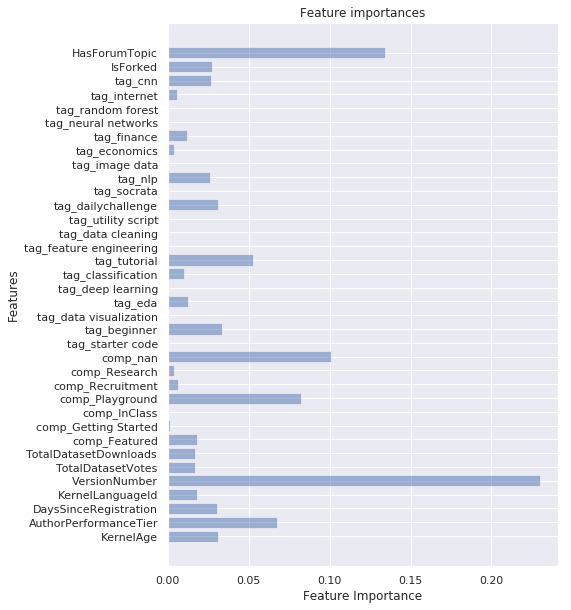

In [51]:
#plot bar chart with matplotlib
plt.figure(figsize=(7,10))

y_pos = np.arange(len(X.columns))

plt.barh(y_pos, xgb.feature_importances_, align='center', alpha=0.5)
plt.yticks(y_pos, X.columns)

plt.ylabel('Features')
plt.xlabel('Feature Importance')

plt.title('Feature importances')

plt.show()

We can explain some of the results:
* __Kernel version number__: this feature may be related to the kernel quality, the kernel with lot's of versions may be updated and improved,
* __Forum topic__: the importance of this feature indicates that a forum topic helps to promote the kernel,
* __Related competition__: we can see that the fact that there is a competition related to a kernel plays a vital role in the number of votes. Probably related competition helps to promote the kernel among the users.
* __Author performance tier__: this feature is essential because more experienced authors create better kernels and have more followers.

So now we can try to predict, how many votes will score __[one of my recent kernels](https://www.kaggle.com/aleksandradeis/bank-marketing-analysis)__:

In [52]:
data = np.array([30, 2, 365, 8, 1, 30, 2070, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
columns = X_train.columns.values

bm_kernel = pd.DataFrame(data = [data], columns = columns)

In [53]:
predict_votes = xgb.predict(bm_kernel)
predict_votes

array([2.6353898], dtype=float32)

The model used to predict around 2 votes for this dataframe. After some enhancements top the features, it predicts 3 votes and that is really close. In fact this kernel has 4 votes (by the time me making this kernel).

## Conclusion

In conclusion, I would like to summarize all the findings and recommendations from this analysis:

1. __It is hard to create a really helpful kernel, which will be appreciated and upvoted by Kagglers__: only 20% of kernels have upvotes and only 4% of kernels have awards (have more than 5 upvotes).
2. __Views and comments bring upvotes__: consider adding a captivating title to the kernel and sharing the link to the kernel with others, the more people will view the kernel - the more people will find it useful.
3. __Active authors have more votes__: try to be an active author and gain visibility, experience in writing kernels and feedback from the others will eventually help to get votes.
4. __It doesn't really matter what topic the kernel is related to, but it matters how the kernel material is presented__: notebooks tend to be more appreciated by Kagglers.

## Updates:
1. Added days since registration for kernel's author as a feature to the model.
2. Added features:
    * KernelAge - number of days since kernel creation,
    * Type of competition related to the kernel ('Featured', 'InClass' etc.). If kernel is not related to a competition the value is NaN. Type of competition is encoded by dummy variables with dedicated column for NaN.
3. Added analysis of feature importances.
4. Analyzed how the advertising of the kernel on Kaggle forum affects the number of votes.
5. Updated bar charts visualizations with rotated labels.
6. Added analysis of number of mentions of kernel on Kaggle forums and the medal rank of the kernel.
7. Updated bar charts: changed to horizontal.